In [2]:
%load_ext autoreload

In [3]:
# imports
%aimport sym
%autoreload 1
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
plt.style.use('dark_background')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)

In [5]:
# data
n_digits = 9
window = (n_digits-3)//2
h_digit,w_digit = (24,8)
transform = transforms.Compose([transforms.CenterCrop((h_digit,20)),
                                transforms.Resize((h_digit,w_digit)),
                               ])
data = transform(imagenet_data_train.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit) #Shuffle Data
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1) #Concatenate digits
data = (data.permute(2,1,0).unsqueeze(1)/255)*2-1 # normalize data
targets = imagenet_data_train.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.reshape(-1,n_digits)[:,window:-window].sum(axis=1)%2
#targets = 2*targets -1 
targets = targets.view(-1,1)
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float()[:-100],targets.float()[:-100]),
                                          batch_size=16,
                                          shuffle=True)

In [6]:
end = len(imagenet_data_val.data)//n_digits * n_digits
data = transform(imagenet_data_val.data[:end]).view(-1,n_digits,h_digit,w_digit) #[:-1]for 3 digits
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1)
data = (data.permute(2,1,0).unsqueeze(1)/255)*2-1
targets = imagenet_data_val.targets[:end].view(-1,n_digits)[:,window:-window].sum(axis=1)%2 #[:-1] for 3 digits
#targets = 2*targets -1 
targets = targets.view(-1,1)
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)

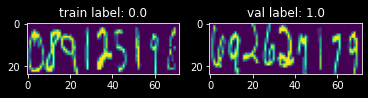

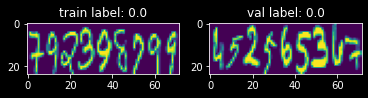

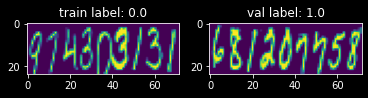

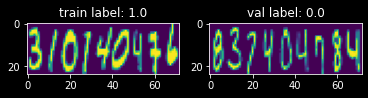

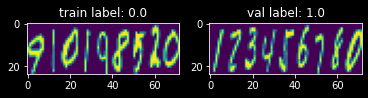

In [7]:
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, axes = plt.subplots(1,2)
    axes[0].set_title(f"train label: {y.item()}")
    axes[1].set_title(f"val label: {y2.item()}")
    axes[0].imshow(x[0])
    axes[1].imshow(x2[0])
    if i==5: break

# Training some models 

In [8]:
T = 30  # epochs
log_step = 1  # validate and print losses every log_steps
lr = 1e-4
criterion = torch.nn.MSELoss()

In [12]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()
def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
    return loss.item()
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        losses_train.append(loss)
        loss = np.mean(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return np.concatenate(losses_train), losses_val
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        targets = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
            targets.append(y.cpu().numpy())
    yhat = np.concatenate(yhat).reshape(-1)>.5
    targets = np.concatenate(targets).reshape(-1)
    out = classification_report(yhat.astype(int),targets.astype(int))
    print(out)
    return 
def plot_loss(losses_train,losses_val,smoothing=None):
    if smoothing is None: 
        y = losses_train.reshape(-1,T).mean(axis=0)
    else:
        y = np.convolve(np.ones(smoothing)/smoothing,losses_train)
    plt.plot(np.linspace(0,T,len(y)),
             y, label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

#  CNN Training

In [10]:
# Train the CNN 
nfilters = 64
stride=8
kernel_size = 24
hidden = 1024
cnn = sym.models.CNN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
cnn.to(device)
cnn.optimizer = torch.optim.Adam(cnn.parameters(),lr=lr)
losses_train_cnn, losses_val_cnn = train_loop(cnn,T=T,log_step=log_step)

Epoch 001/30  | Training loss: 0.2503 - Validation loss: 0.2501
Epoch 002/30  | Training loss: 0.2497 - Validation loss: 0.2501
Epoch 003/30  | Training loss: 0.2443 - Validation loss: 0.2440
Epoch 004/30  | Training loss: 0.2245 - Validation loss: 0.2109
Epoch 005/30  | Training loss: 0.1993 - Validation loss: 0.2019
Epoch 006/30  | Training loss: 0.1840 - Validation loss: 0.1916
Epoch 007/30  | Training loss: 0.1680 - Validation loss: 0.1774
Epoch 008/30  | Training loss: 0.1488 - Validation loss: 0.1572
Epoch 009/30  | Training loss: 0.1274 - Validation loss: 0.1398
Epoch 010/30  | Training loss: 0.1068 - Validation loss: 0.1251
Epoch 011/30  | Training loss: 0.0891 - Validation loss: 0.1093
Epoch 012/30  | Training loss: 0.0755 - Validation loss: 0.1029
Epoch 013/30  | Training loss: 0.0646 - Validation loss: 0.1030
Epoch 014/30  | Training loss: 0.0554 - Validation loss: 0.1031
Epoch 015/30  | Training loss: 0.0468 - Validation loss: 0.1048
Epoch 016/30  | Training loss: 0.0399 - 

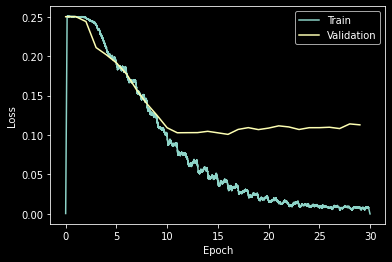

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       546
           1       0.86      0.85      0.85       565

    accuracy                           0.85      1111
   macro avg       0.85      0.85      0.85      1111
weighted avg       0.85      0.85      0.85      1111



In [13]:
plot_loss(losses_train_cnn, losses_val_cnn,smoothing=500)
metrics(cnn)

# LCN Training

In [36]:
%autoreload

In [14]:
# Train the lcn
nfilters = 64
stride=8
kernel_size = 24
hidden = 1024
lcn = sym.models.LCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
lcn.to(device)
lcn.optimizer = torch.optim.Adam(lcn.parameters(),lr=lr)
losses_train_lcn, losses_val_lcn = train_loop(lcn,T=T,log_step=log_step)

Epoch 001/30  | Training loss: 0.2506 - Validation loss: 0.2498
Epoch 002/30  | Training loss: 0.2481 - Validation loss: 0.2411
Epoch 003/30  | Training loss: 0.2211 - Validation loss: 0.2144
Epoch 004/30  | Training loss: 0.1977 - Validation loss: 0.1931
Epoch 005/30  | Training loss: 0.1800 - Validation loss: 0.1879
Epoch 006/30  | Training loss: 0.1576 - Validation loss: 0.1628
Epoch 007/30  | Training loss: 0.1319 - Validation loss: 0.1531
Epoch 008/30  | Training loss: 0.1080 - Validation loss: 0.1319
Epoch 009/30  | Training loss: 0.0886 - Validation loss: 0.1392
Epoch 010/30  | Training loss: 0.0731 - Validation loss: 0.1353
Epoch 011/30  | Training loss: 0.0606 - Validation loss: 0.1252
Epoch 012/30  | Training loss: 0.0506 - Validation loss: 0.1379
Epoch 013/30  | Training loss: 0.0428 - Validation loss: 0.1299
Epoch 014/30  | Training loss: 0.0362 - Validation loss: 0.1359
Epoch 015/30  | Training loss: 0.0310 - Validation loss: 0.1394
Epoch 016/30  | Training loss: 0.0270 - 

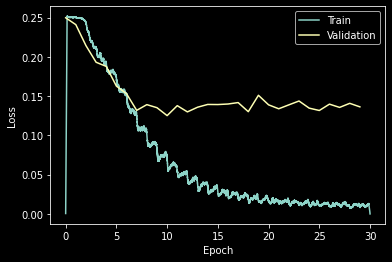

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       537
           1       0.85      0.83      0.84       574

    accuracy                           0.83      1111
   macro avg       0.83      0.83      0.83      1111
weighted avg       0.83      0.83      0.83      1111



In [15]:
plot_loss(losses_train_lcn, losses_val_lcn,smoothing=500)
metrics(lcn)

# FCN Training

In [15]:
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(h_digit*w_digit*n_digits, nfilters), #* more for full fcn width
                          #torch.nn.BatchNorm1d(nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters,hidden),
                          torch.nn.ReLU(),
                          torch.nn.Linear(hidden, 1),
                          torch.nn.Sigmoid(),)
fcn.to(device)
fcn.optimizer = torch.optim.Adam(fcn.parameters(), lr=lr)
losses_train_fcn, losses_val_fcn = train_loop(fcn, T=T, log_step=log_step)

Epoch 001/30  | Training loss: 0.2506 - Validation loss: 0.2502
Epoch 002/30  | Training loss: 0.2502 - Validation loss: 0.2502
Epoch 003/30  | Training loss: 0.2500 - Validation loss: 0.2505
Epoch 004/30  | Training loss: 0.2497 - Validation loss: 0.2502
Epoch 005/30  | Training loss: 0.2490 - Validation loss: 0.2509
Epoch 006/30  | Training loss: 0.2461 - Validation loss: 0.2549
Epoch 007/30  | Training loss: 0.2363 - Validation loss: 0.2539
Epoch 008/30  | Training loss: 0.2196 - Validation loss: 0.2561
Epoch 009/30  | Training loss: 0.1985 - Validation loss: 0.2394
Epoch 010/30  | Training loss: 0.1778 - Validation loss: 0.2421
Epoch 011/30  | Training loss: 0.1583 - Validation loss: 0.2485
Epoch 012/30  | Training loss: 0.1402 - Validation loss: 0.2620
Epoch 013/30  | Training loss: 0.1225 - Validation loss: 0.2533
Epoch 014/30  | Training loss: 0.1071 - Validation loss: 0.2666
Epoch 015/30  | Training loss: 0.0936 - Validation loss: 0.2806
Epoch 016/30  | Training loss: 0.0833 - 

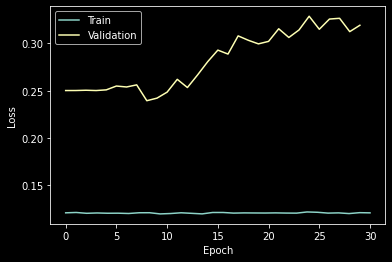

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       544
           1       0.64      0.63      0.64       567

    accuracy                           0.63      1111
   macro avg       0.63      0.63      0.63      1111
weighted avg       0.63      0.63      0.63      1111



In [16]:
plot_loss(losses_train_fcn, losses_val_fcn)
metrics(fcn)

In [190]:
def Misalignment2(A,B):
    evalA,evecA = np.linalg.eig(A)
    M = 0
    for evec in evecA:
        a = np.dot(evec,np.matmul(B,evec))
        b = np.dot(evec,np.matmul(np.linalg.inv(B),evec))
        M += np.sqrt(a*b)-1
    return M
def cov(filters):
    mu = filters.mean(axis=0)
    x_bar = filters - mu 
    cov_filters = np.array([np.matmul(x.reshape(-1,1),x.reshape(1,-1)) for x in x_bar]).sum(axis=0)
    return cov_filters
def cov2(filters):
    filters = filters.reshape(filters.shape[0],-1)
    cov_filters = np.matmul(filters.T,filters)
    return cov_filters
def get_misalignments(cnn,lcn,rand=None):
    span = 7
    filters = list(cnn.conv_blocks.parameters())[0].cpu().squeeze().detach().numpy()
    filters_by_loc = list(lcn.conv_blocks.parameters())[0].unflatten(0,(nfilters,span)).cpu().squeeze().detach().numpy()
    cov_filters_cnn = cov2(filters)
    missalignments = []
    if rand is not None:
         missalignments.append(Misalignment2(rand,cov2(filters_by_loc[:,span//2])))
    for i in range(span):
        cov_filters_lcn = cov2(filters_by_loc[:,i])
        missalignments.append(Misalignment2(cov_filters_cnn,cov_filters_lcn))
    return missalignments

In [194]:
def train_loop2(models, T=10, log_step=1):
    losses_train = []
    losses_val = []
    rand, _ = np.linalg.qr(np.random.randn(h_digit*w_digit*3,h_digit*w_digit*3))
    for model in models:
        model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss0 = list()  # Combine losses from differetn steps in a single epoch
        loss1 = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss0_ = train(models[0], x, y)
            loss0.append(loss0_)
            loss1_ = train(models[1], x, y)
            loss1.append(loss1_)
            print(f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: [0] {loss0_:^.4f};"+
                  f" [1] {loss1_:^.4f}", end="\r")
        losses_train.append([loss0,loss1])
        loss0 = np.mean(loss0)
        loss1 = np.mean(loss1)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: [0] {loss0:^.4f}; [1] {loss1:^.4f} - "
            loss0 = []
            loss1 = []
            missalign = []
            with torch.no_grad():
                for x, y in valloader:
                    loss0_ = validate(models[0], x, y)
                    loss1_ = validate(models[1], x, y)
                    loss0.append(loss0_)
                    loss1.append(loss1_)
            loss0 = np.mean(loss0)
            loss1 = np.mean(loss1)
            losses_val.append([loss0,loss1])
            message += f"Validation loss: [0] {loss0:^.4f}; [1] {loss1:^.4f}"
            miss = get_misalignments(models[0],models[1],rand=rand)
            missalign.append(miss)
            message += "| Missalignment:" + " - ".join([f"{m:^.4f}" for m in missalign])
            print(message)  # ,end="\r"
    return np.stack(losses_train), losses_val, missalign

In [195]:
# Train both
T=30
nfilters = 1024
cnn0 = sym.models.CNN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
cnn0.to(device)
cnn0.optimizer = torch.optim.Adam(cnn0.parameters(),lr=lr)
lcn0 = sym.models.LCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Sigmoid())
lcn0.to(device)
lcn0.optimizer = torch.optim.Adam(lcn0.parameters(),lr=lr)
losses_train, losses_val, missalign = train_loop2([cnn0,lcn0],T=T,log_step=log_step)

TypeError: 'NoneType' object is not iterable

# Plot Filters

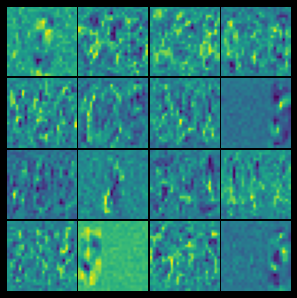

In [140]:
filters = list(cnn0.conv_blocks.parameters())[0].cpu().squeeze().detach().numpy()
fig,axes = plt.subplots(4,4,figsize=(4,4))
for filt,ax in zip(filters[:16],axes.flatten()):
    ax.imshow(filt)
    ax.axis("off")
fig.tight_layout(pad=0.2)

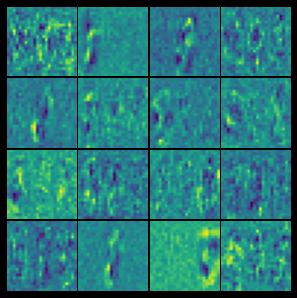

In [138]:
filters_by_loc = list(lcn0.conv_blocks.parameters())[0].unflatten(0,(64,7)).cpu().squeeze().detach().numpy()
fig,axes = plt.subplots(4,4,figsize=(4,4))
for filt,ax in zip(filters_by_loc[0:,3],axes.flatten()):
    ax.imshow(filt)
    ax.axis("off")
fig.tight_layout(pad=0.2)

In [149]:
a = np.random.randn(64,12)
np.linalg.det(cov2(a))

1.1706537496500537e+21

In [158]:
cov_filters_cnn

array([[ 0.04766598,  0.00671926,  0.00317734, ..., -0.00084907,
         0.01217991,  0.01207791],
       [ 0.00671926,  0.03677524,  0.00479253, ...,  0.00351797,
         0.00777689,  0.00380293],
       [ 0.00317734,  0.00479253,  0.04066061, ...,  0.01141658,
        -0.00433686,  0.00838426],
       ...,
       [-0.00084907,  0.00351797,  0.01141658, ...,  0.13133469,
         0.05158224,  0.0161288 ],
       [ 0.01217991,  0.00777689, -0.00433686, ...,  0.05158224,
         0.09805496,  0.01668933],
       [ 0.01207791,  0.00380293,  0.00838426, ...,  0.0161288 ,
         0.01668933,  0.0582136 ]], dtype=float32)

In [102]:
# cov_filters = np.matmul(filters.reshape(-1,24**2).T,filters.reshape(-1,24**2)) -\
# np.matmul(filters.reshape(-1,24**2).mean(axis=0).reshape(-1,1),filters.reshape(-1,24**2).mean(axis=0).reshape(1,-1))
# cov_filters = cov_filters.reshape(24**2,24**2)


In [103]:
np.linalg.det(cov_filters_lcn)

0.0

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


nan

In [22]:
eigvalues, eigvectors = np.linalg.eig(cov_filters)

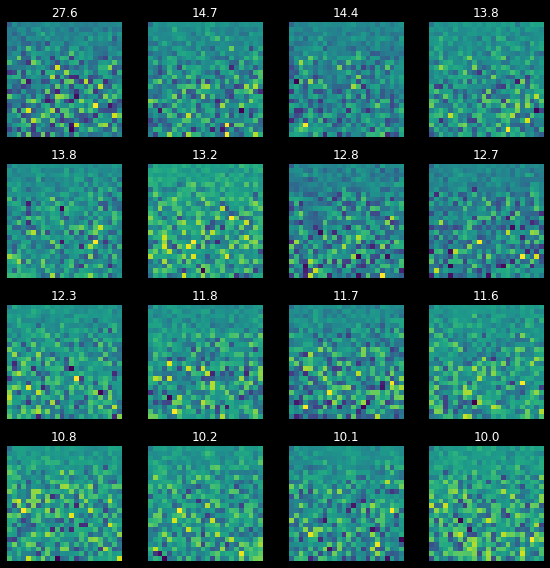

In [71]:
fig,axes = plt.subplots(4,4,figsize=(8,8))
for i,ax in enumerate(axes.flatten()):
    ax.imshow(eigvectors[i].reshape(24,24))
    ax.axis("off")
    ax.set_title(f"{eigvalues[i]:.1f}")
fig.tight_layout()
